# Прогнозирование уровня средней заработной платы в России

В файле 'WAG_C_M.csv' записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


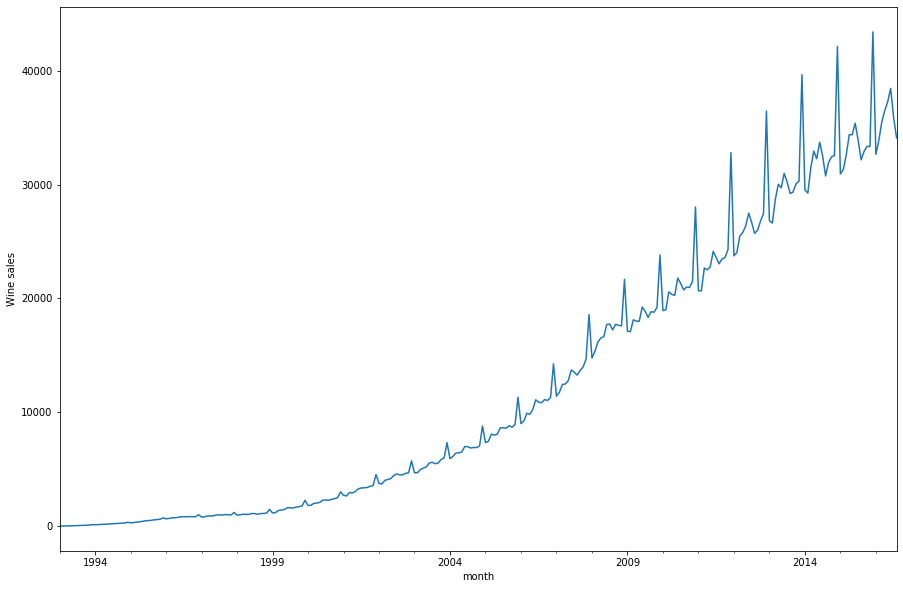

In [15]:
wag = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,10))
wag.WAG_C_M.plot()
plt.ylabel('Wine sales')
pylab.show()

Видно, что ряд не стационарен, имеет нелинейный тренд, нестационарную дисперсию - размах сезонных колебаний здесь в начале ряда немного меньше,
чем вот здесь, ближе к концу ряда. 

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584


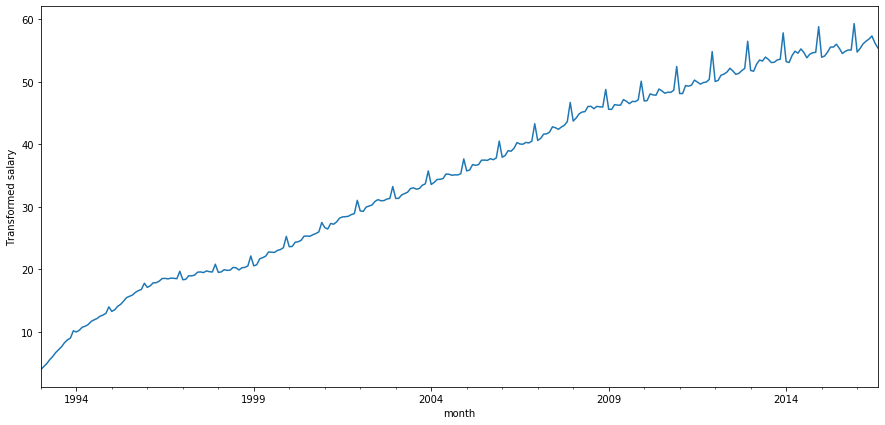

In [24]:
wag['box_salary'], lmbda = stats.boxcox(wag.WAG_C_M)
plt.figure(figsize(15,7))
wag.box_salary.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: {}".format(lmbda))

### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697133494791847


<Figure size 1080x720 with 0 Axes>

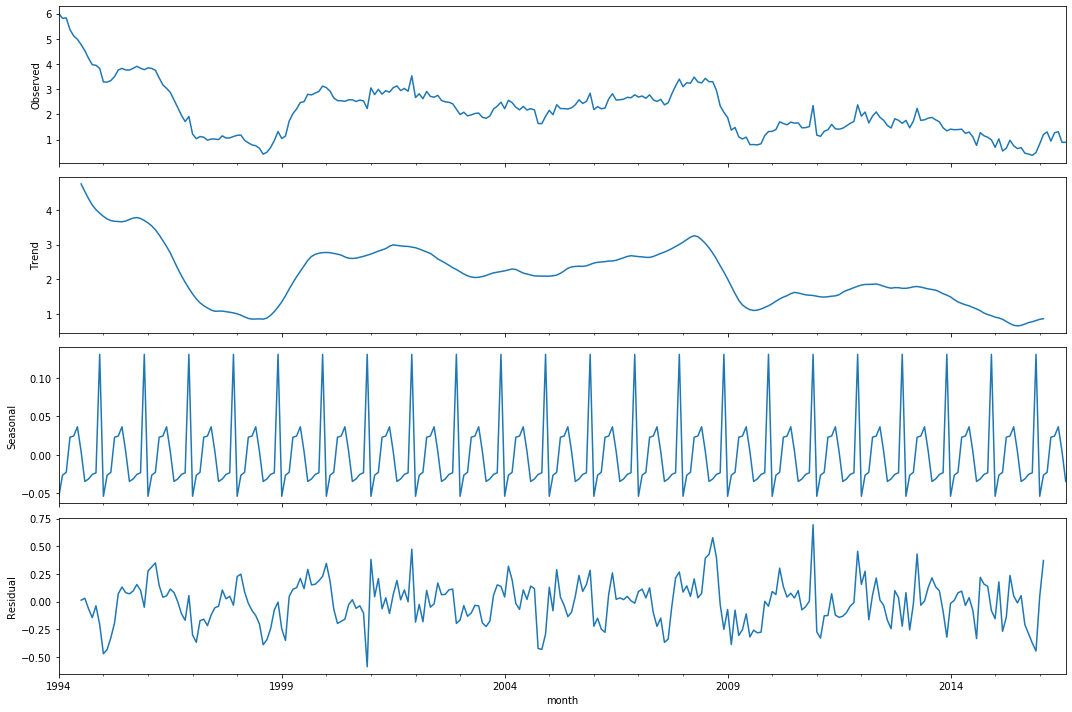

In [23]:
wag['diff_box_salary'] = wag.box_salary - wag.box_salary.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.diff_box_salary[12:]).plot()
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(wag.diff_box_salary[12:])[1]))

Сезонный профиль достаточно хорошо выражен.
Тренд имеет достаточно сложную структуру.
Сначала он понижается, затем доходит до плато,
немного понижается и сохраняет уровень.
Это ещё раз нам подтверждает, что ряд трудно считать стационарным. 

Хотя критерий Дики-Фуллера отвергает гипотезу нестационарности, избавиться от тренда не удалось. Попробуем добавить обычное дифференцирование:

Критерий Дики-Фуллера: p=5.203603715821792e-08


<Figure size 1080x720 with 0 Axes>

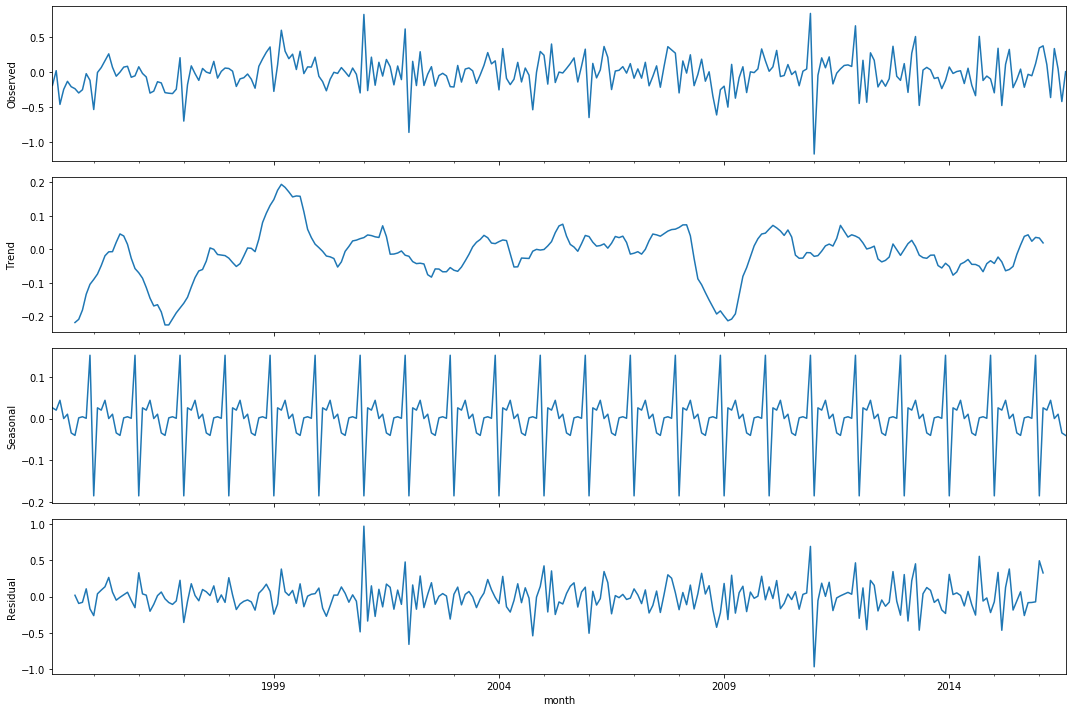

In [22]:
wag['diff2_box_salary'] = wag.diff_box_salary - wag.diff_box_salary.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.diff2_box_salary[13:]).plot()   
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(wag.diff2_box_salary[13:])[1]))

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренд теперь не выглядит систематичным.

Будем считать этот ряд стационарным.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

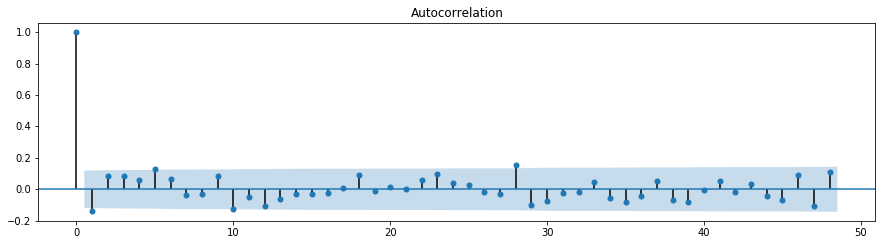

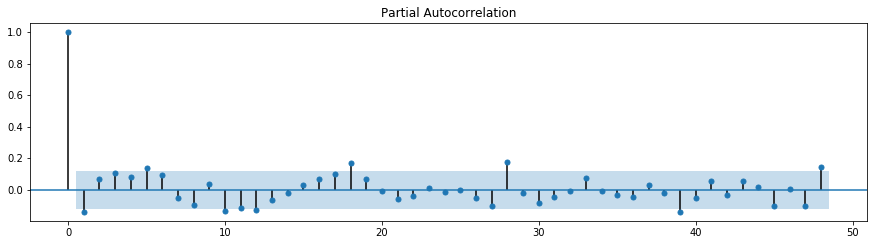

In [25]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.diff2_box_salary[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.diff2_box_salary[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Глядя на графики, выберем следующие начальные приближения:

Q = 0, q = 1, P = 2, p = 1.

In [26]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

Определим количество перебираемых моделей:

In [27]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [28]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag.box_salary, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 5.21 s


In [29]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
10  (1, 0, 1, 0)  0.340521
11  (1, 0, 1, 1)  0.492412
9   (1, 0, 0, 1)  0.774438
6   (0, 1, 1, 0)  1.170768
7   (0, 1, 1, 1)  1.342395


Видно, что изначально подобрали параметры не самым удачным образом, но лучшая модель определена, она ещё и является более простой.

Лучшая модель:

In [30]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         box_salary   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 12 May 2020   AIC                              0.341
Time:                                    23:59:50   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090793
Критерий Дики-Фуллера: p=0.000003


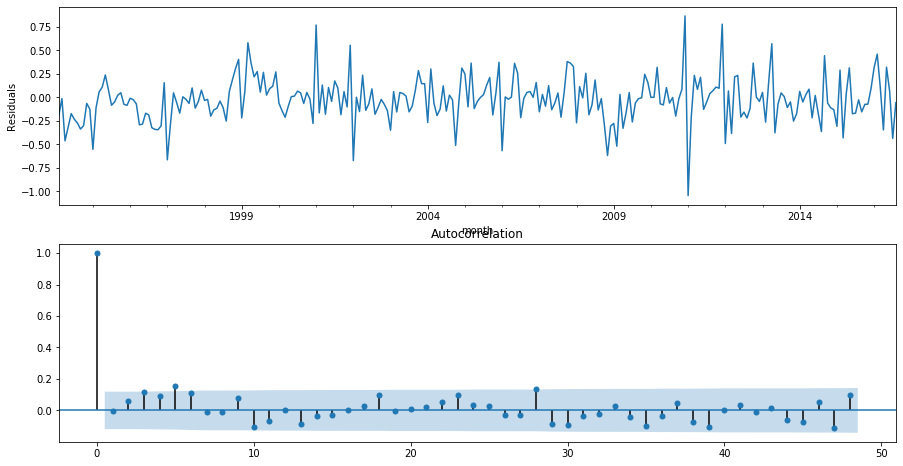

In [32]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки не смещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [61]:
# обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

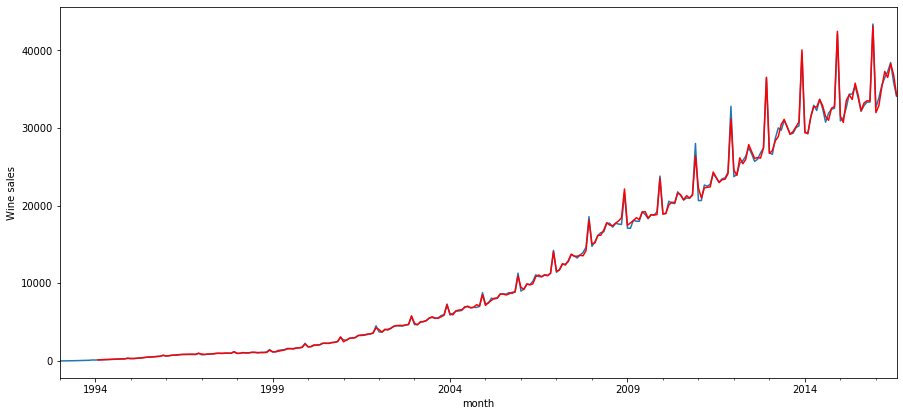

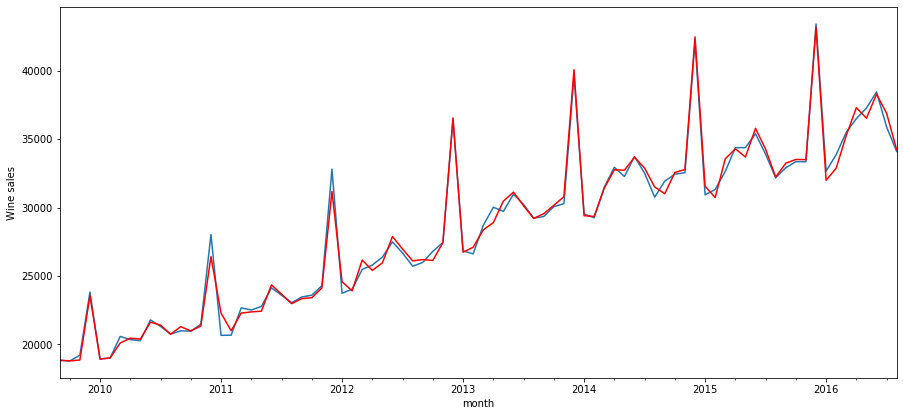

In [60]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,15))
plt.subplot(211)
wag.WAG_C_M.plot()
wag.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

plt.subplot(211)
wag.WAG_C_M[200:].plot()
wag.model[200:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Действительно модель и данные достаточно похожи друг на друга.

### Прогноз

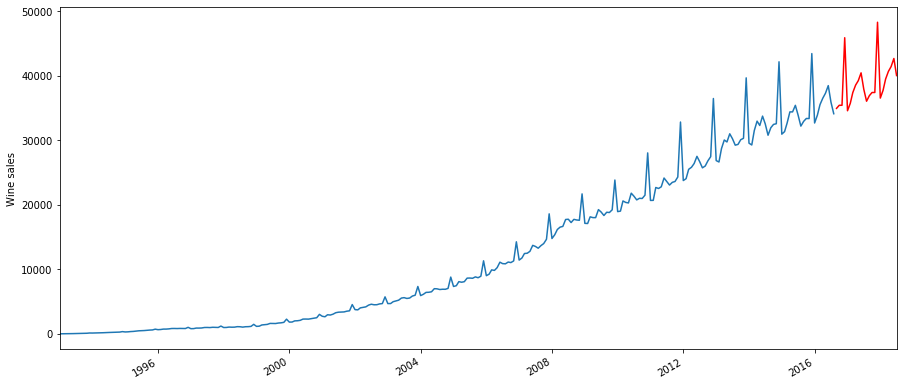

In [56]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=wag.shape[0], end=wag.shape[0]+23), lmbda)

plt.figure(figsize(15,7))
wag2.WAG_C_M.plot()
wag2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [57]:
wag2.tail()

,WAG_C_M,forecast
2018-03-01,NaN,39466.009427
2018-04-01,NaN,40646.451729
2018-05-01,NaN,41387.343229
2018-06-01,NaN,42646.076603
2018-07-01,NaN,40000.822570


**Заключение:** Прогноз выглядит достаточно адекватным.
Он передаёт то, что мы знаем о сезонности,
глядя на предыдущий кусок ряда, и в нём даже присутсвтует тренд. 